In [1]:
!pip install scikit-learn pandas joblib imbalanced-learn

  Using cached imbalanced_learn-0.14.0-py3-none-any.whl.metadata (8.8 kB)
Using cached imbalanced_learn-0.14.0-py3-none-any.whl (239 kB)


In [2]:
!pip install s3fs

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from imblearn.over_sampling import SMOTE # Import SMOTE
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [4]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

# 1. Get the execution role (just to verify the session is active)
role = get_execution_role()

# 2. Define YOUR specific bucket and file name
# (I updated these to match your project details)
bucket = 'iu-fraud-project-s3'
data_key = 'creditcard.csv'

# 3. Construct the full S3 path
data_location = 's3://{}/{}'.format(bucket, data_key)
print(f"Attempting to load from: {data_location}")

# 4. Try to load the data using pandas
try:
    df = pd.read_csv(data_location)
    print("Successful! Data loaded.")
    print(f"Shape: {df.shape}")
    print(df.head())
except Exception as e:
    print(f"Error loading data: {e}")
    print("If this fails, double-check that you added the Inline Policy to your IAM Role.")

Attempting to load from: s3://iu-fraud-project-s3/creditcard.csv
Successful! Data loaded.
Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -

In [5]:
df.shape

(284807, 31)

# Features

<Axes: xlabel='Class'>

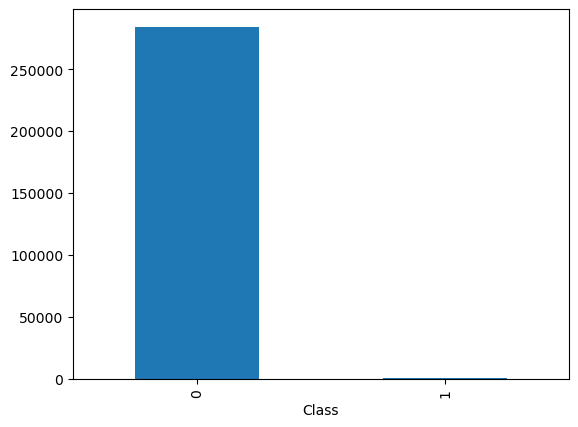

In [6]:
df['Class'].value_counts().plot.bar()

## Univariate analysis

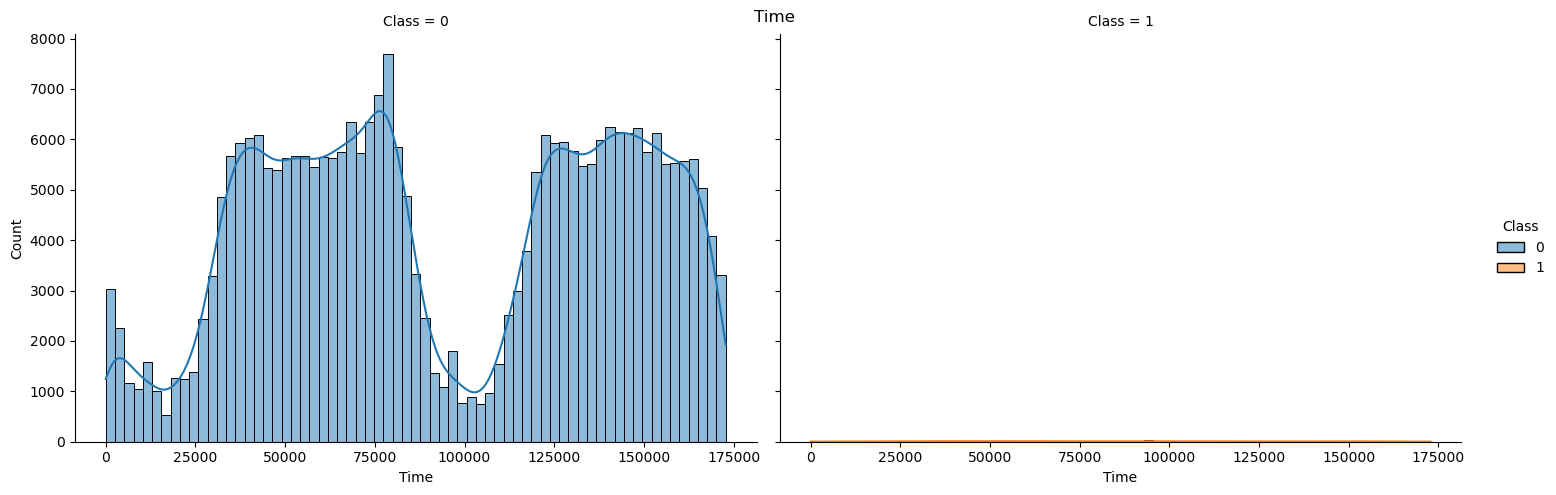

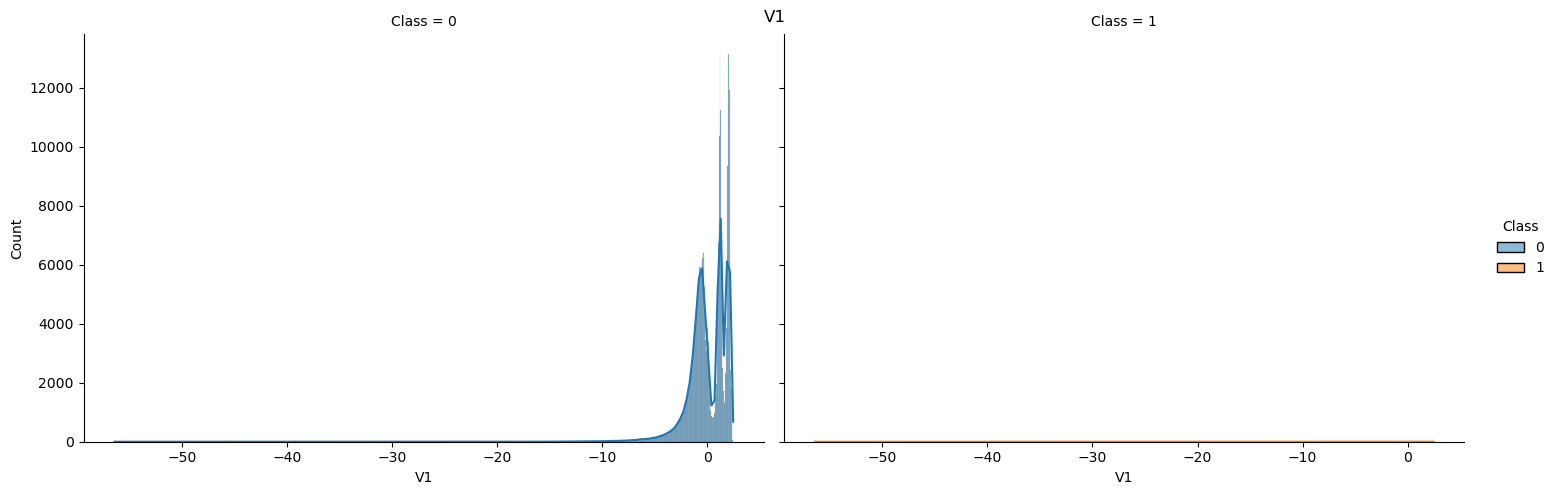

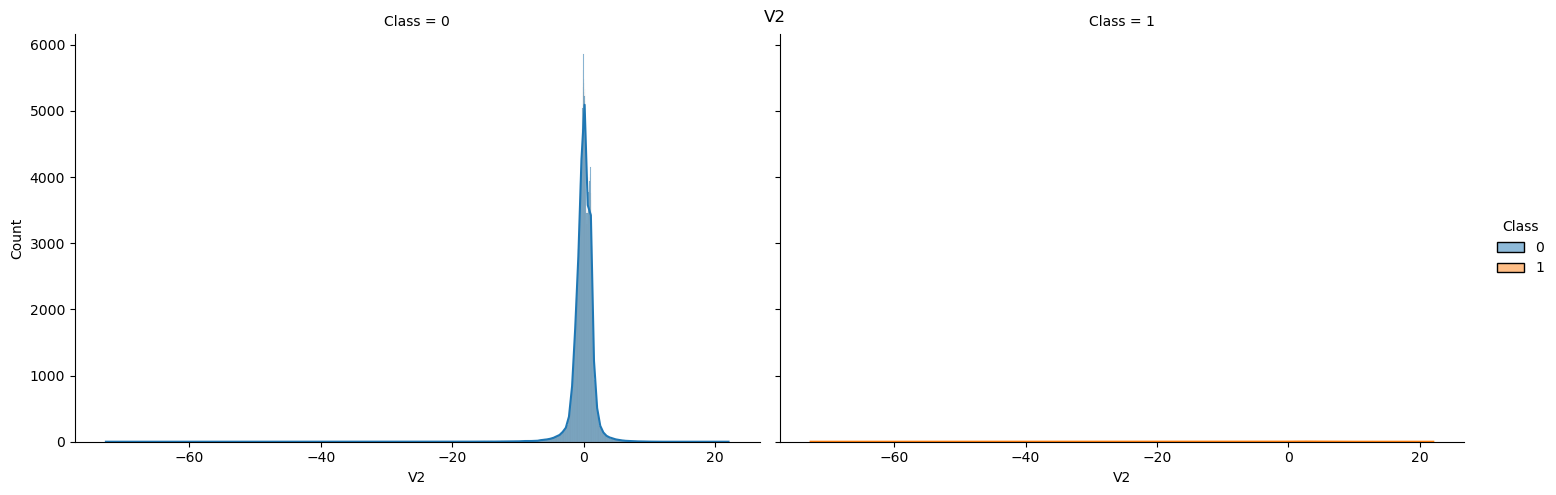

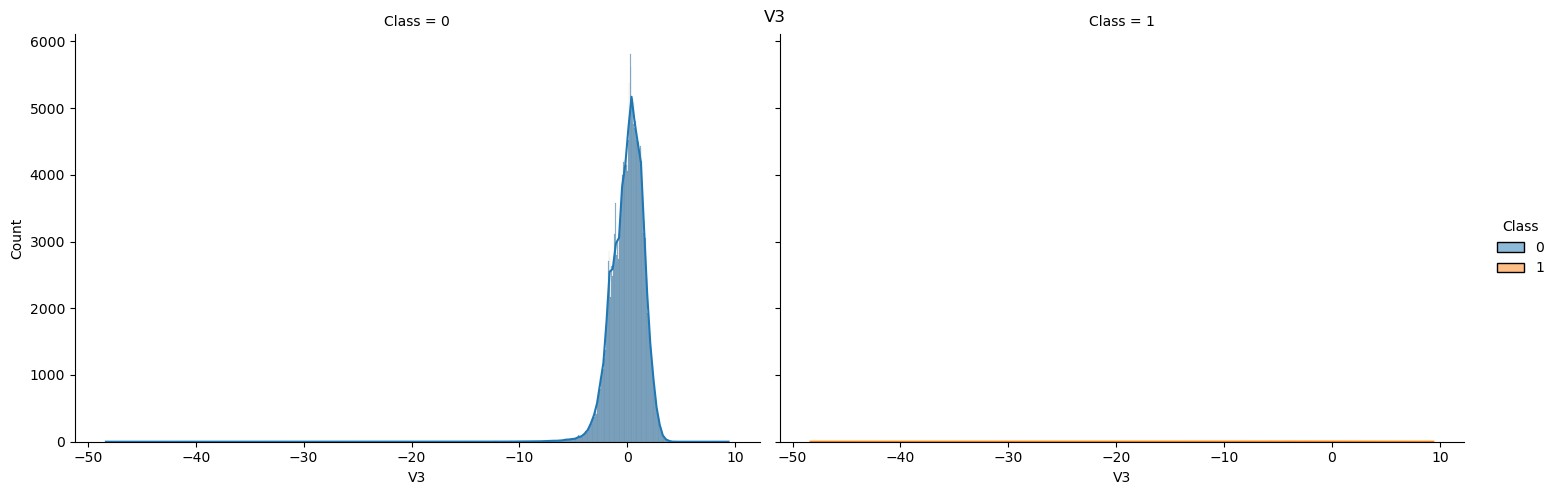

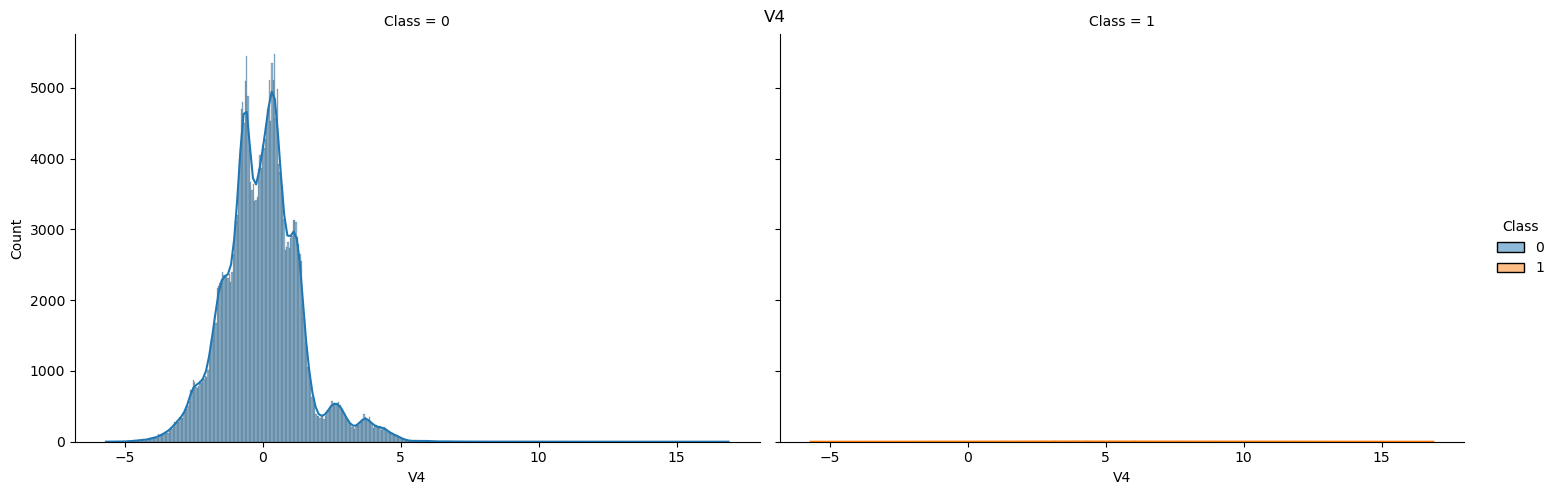

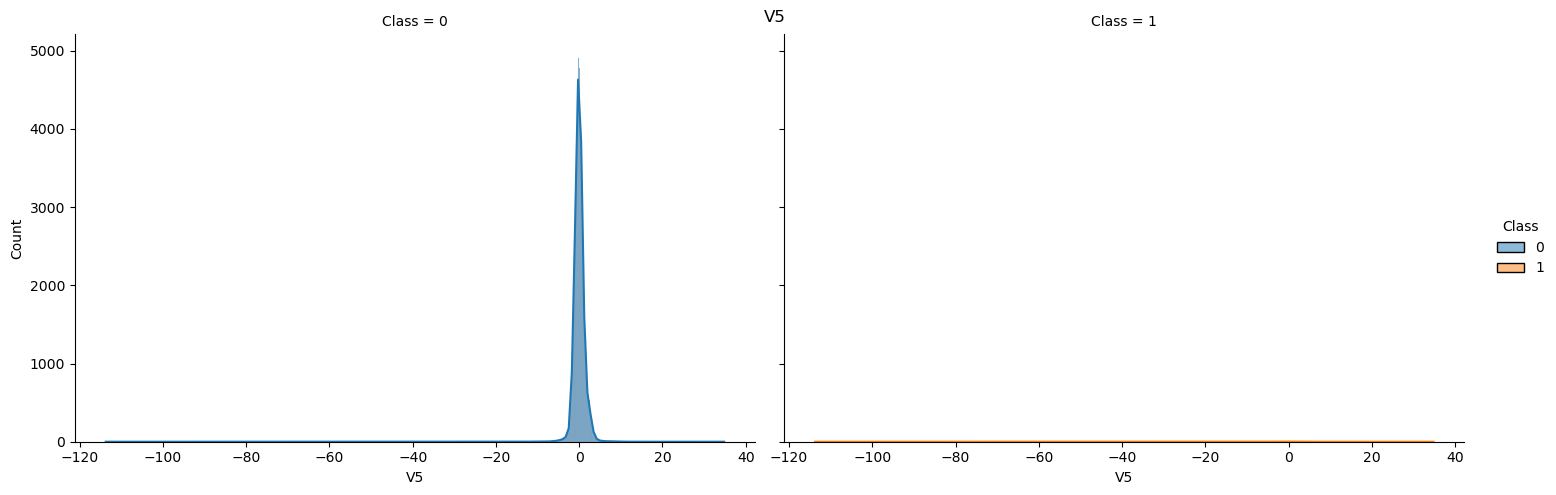

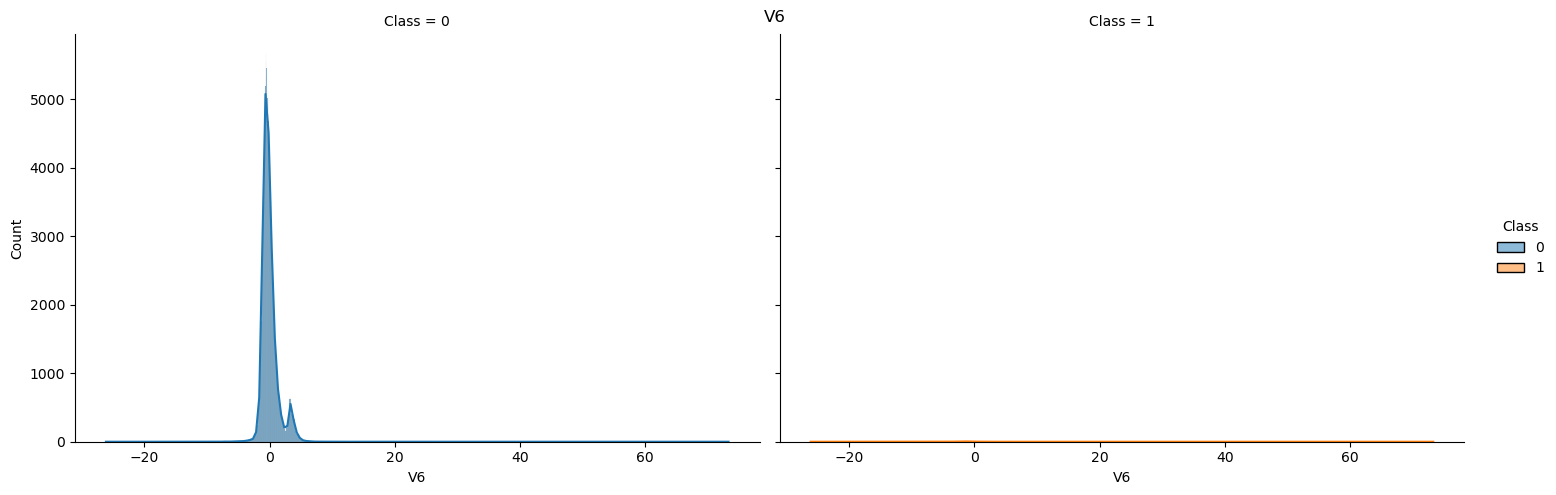

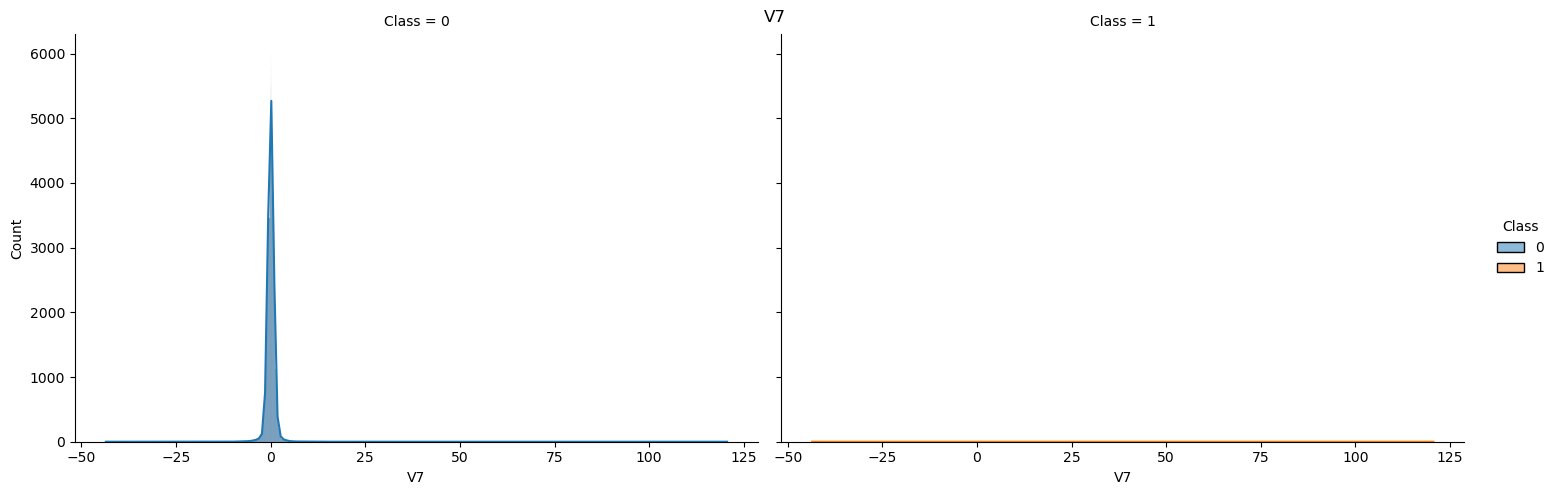

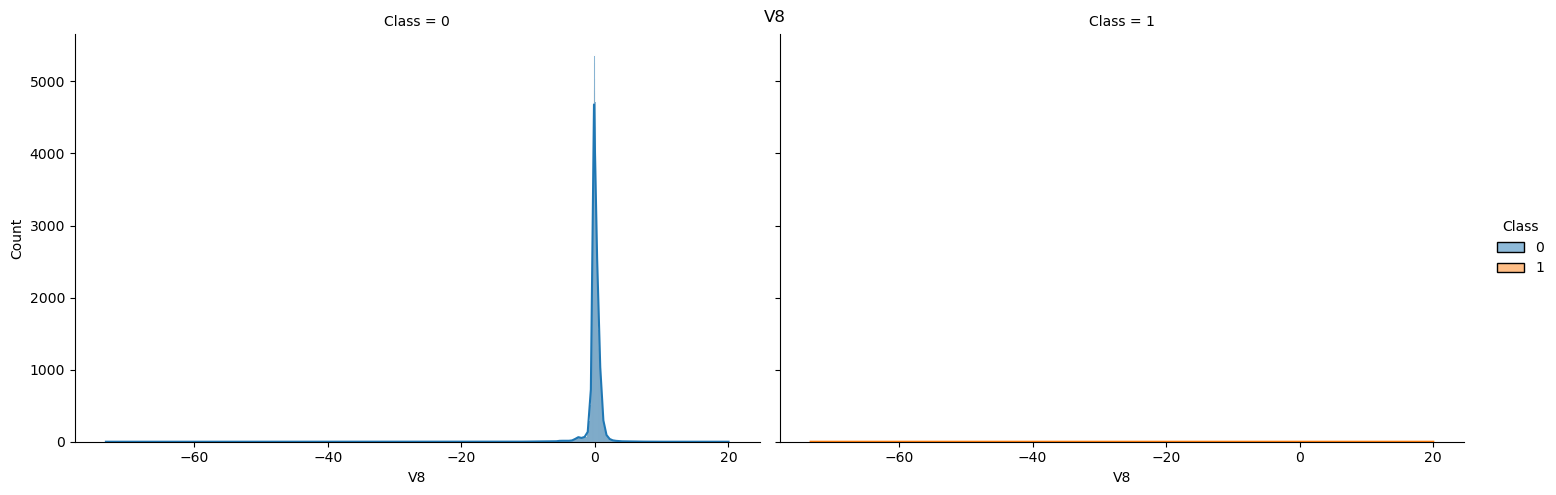

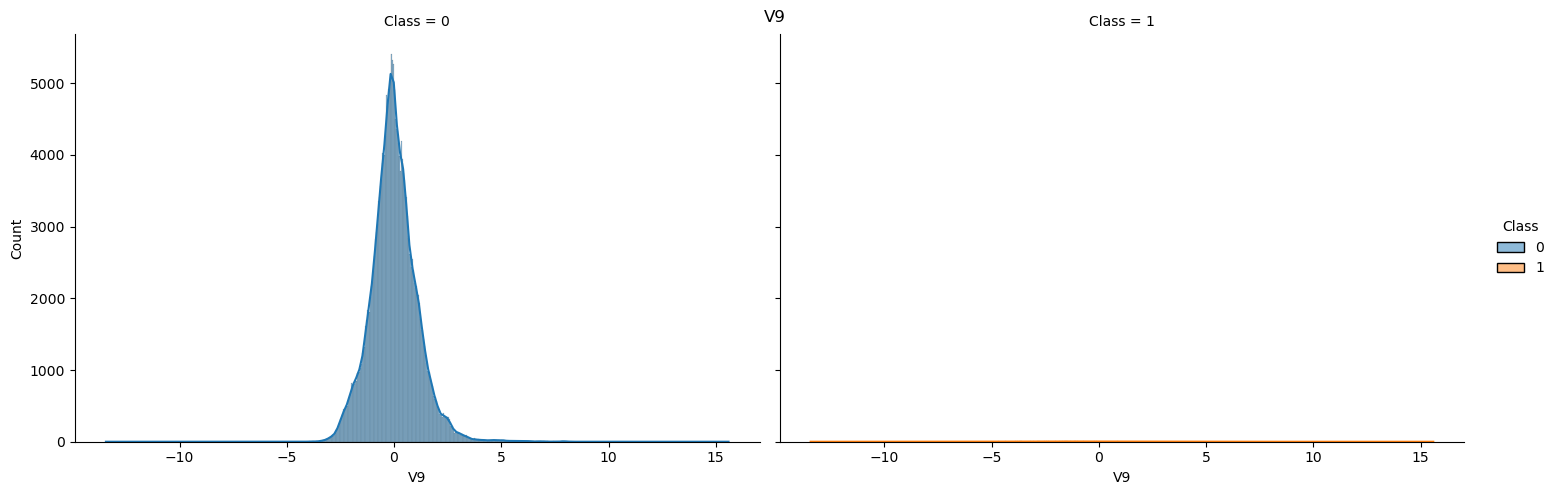

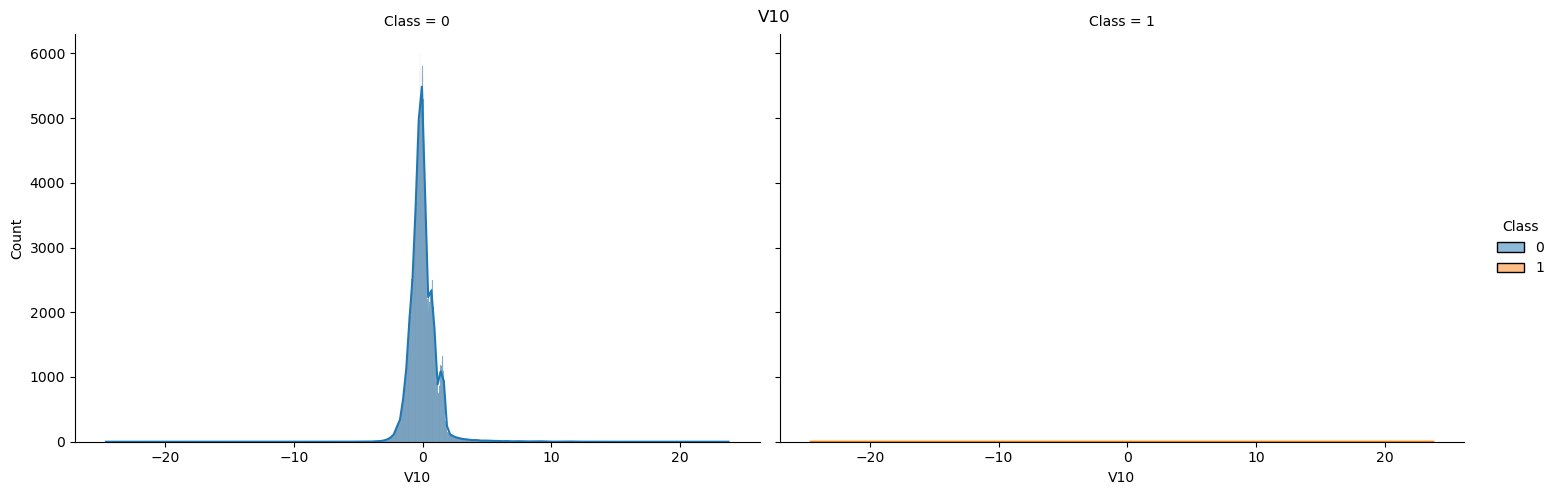

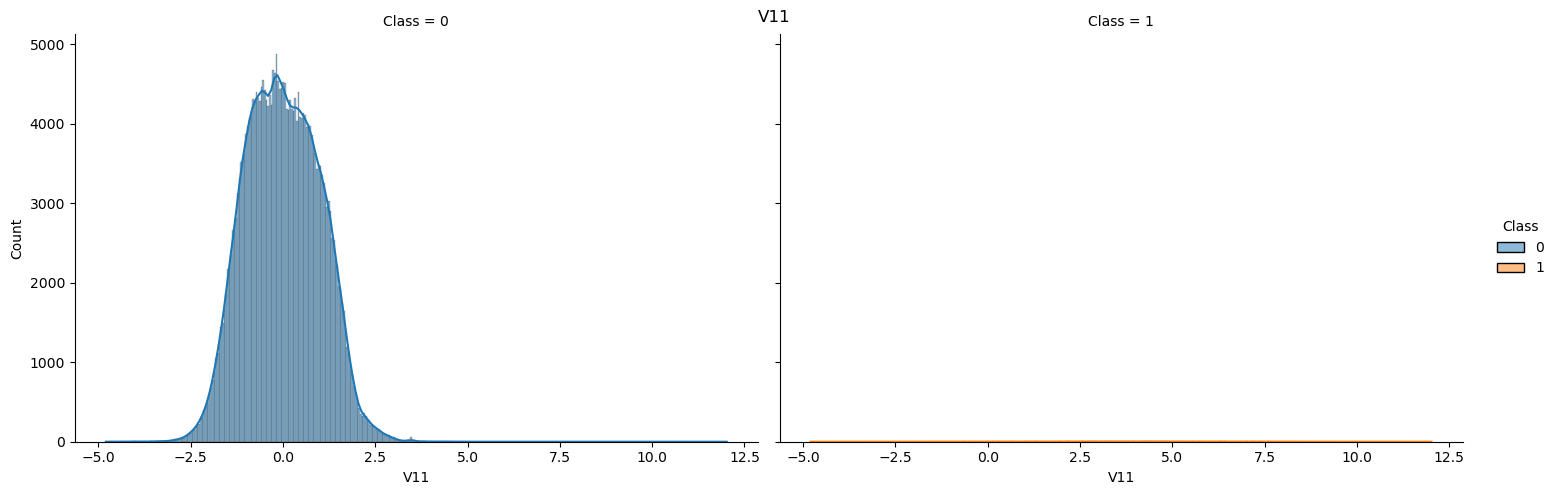

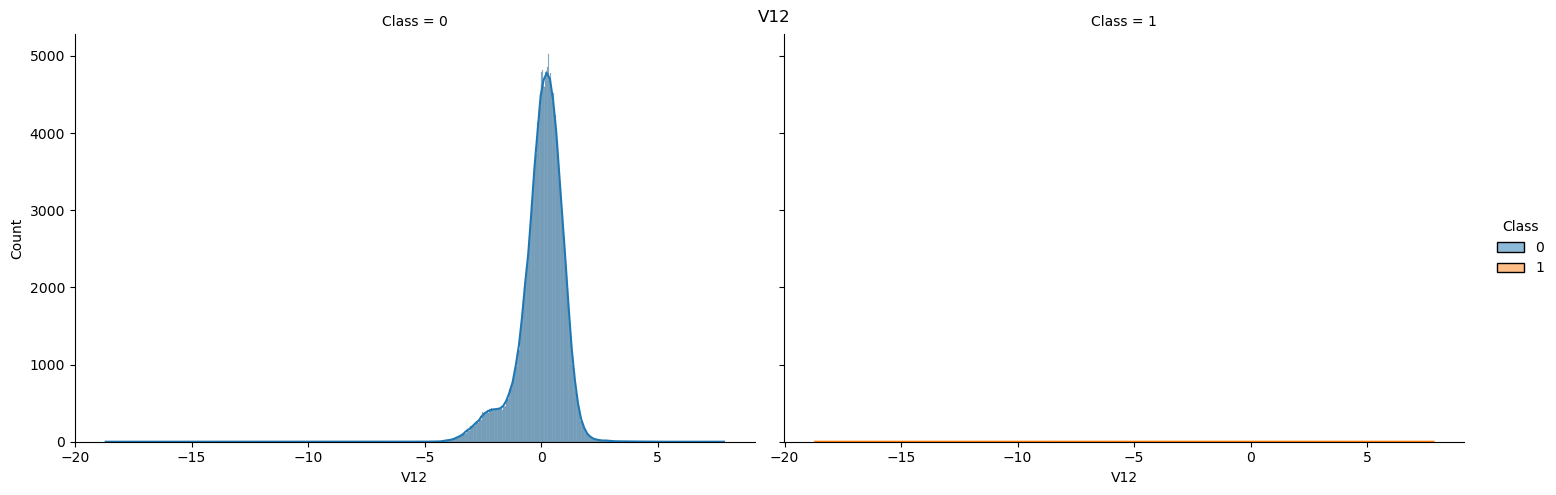

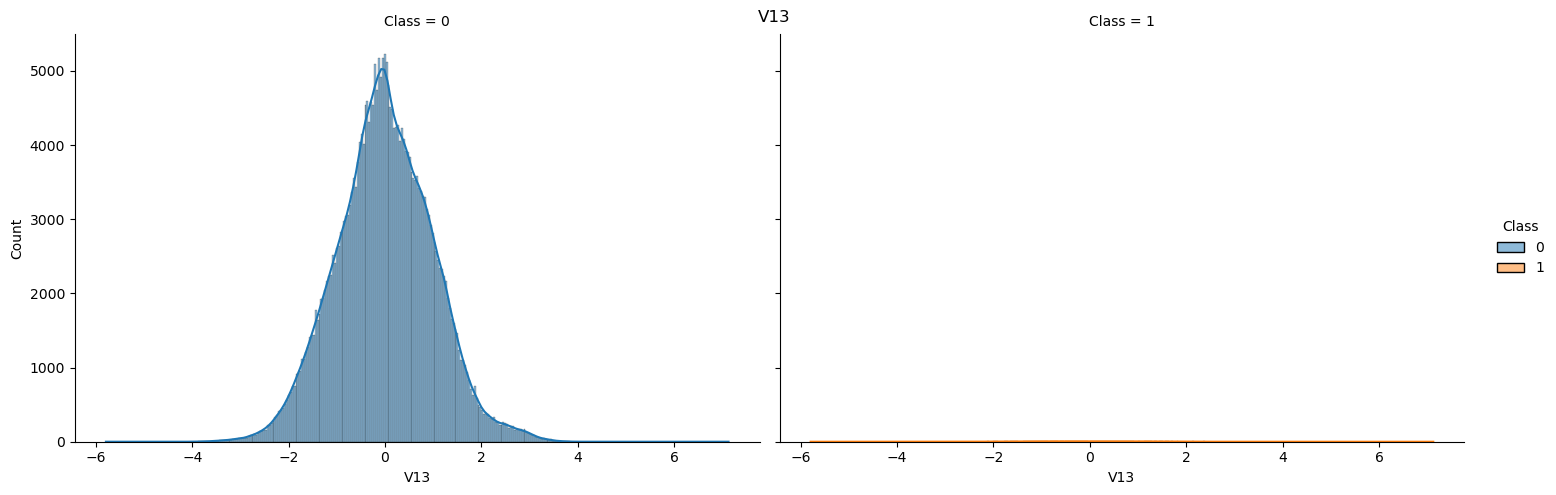

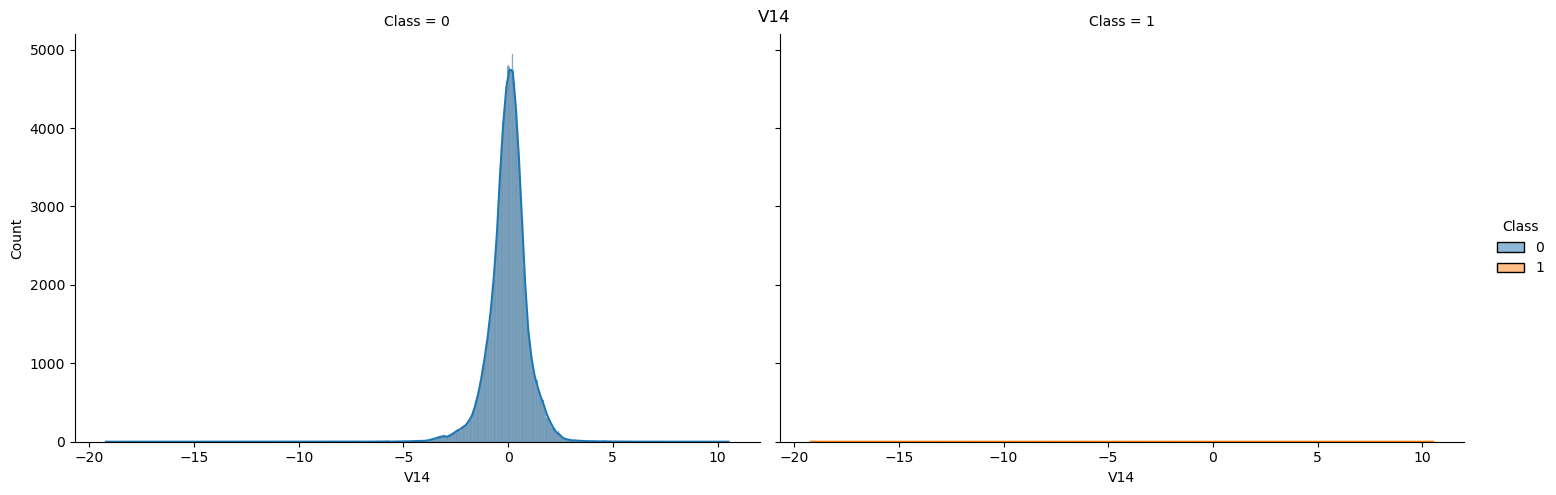

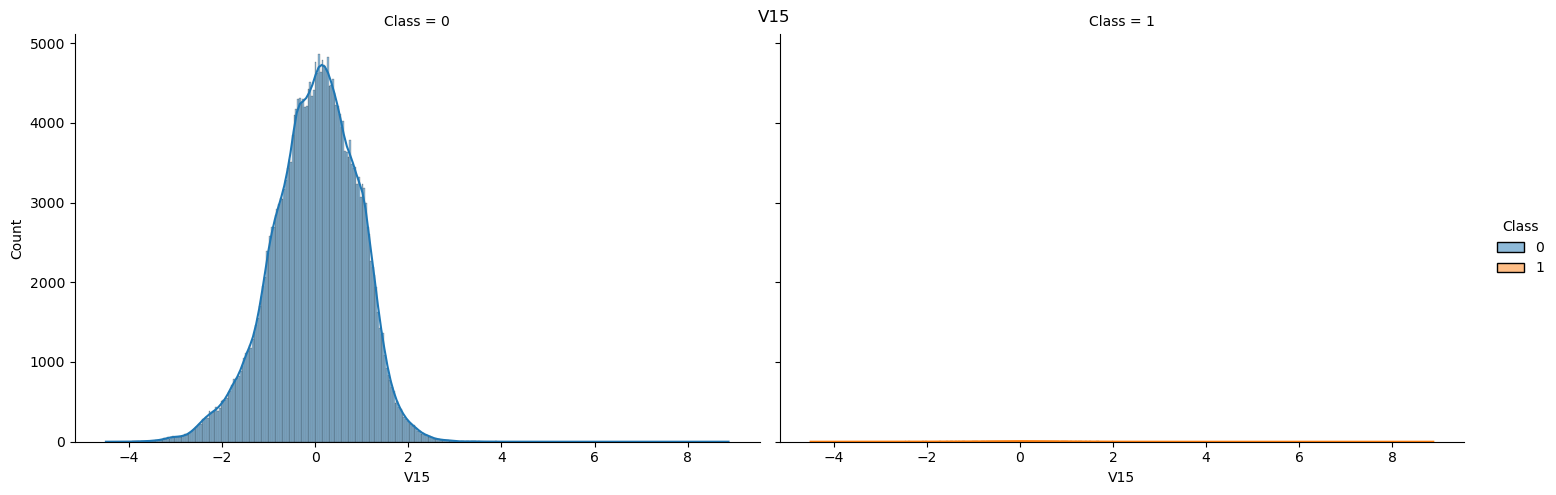

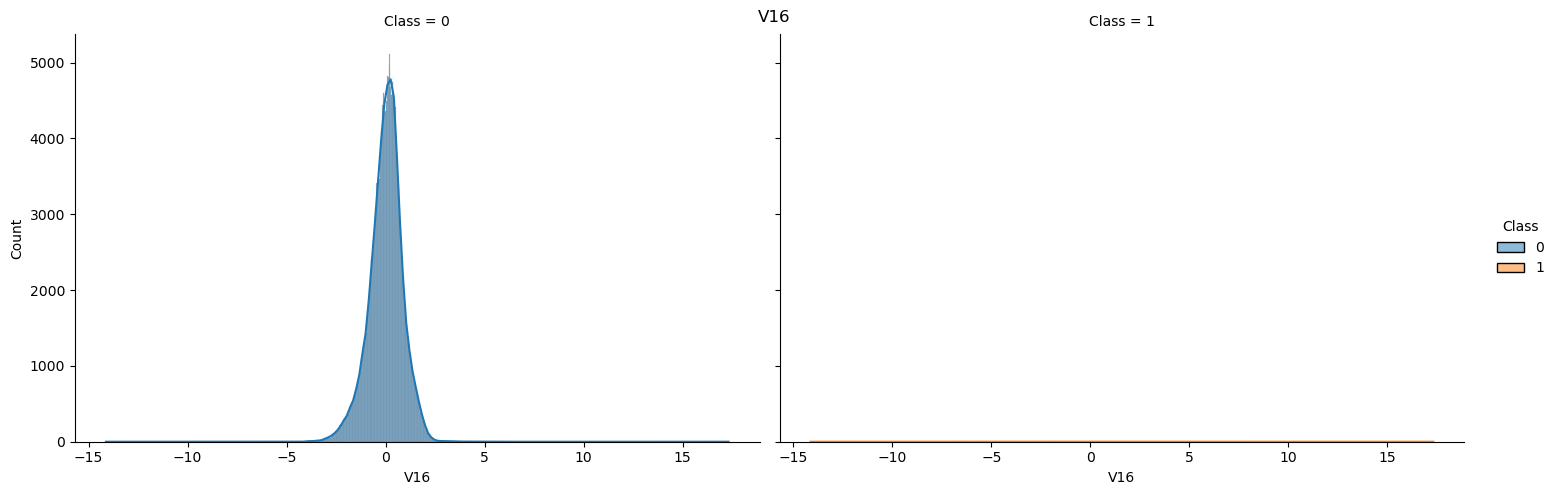

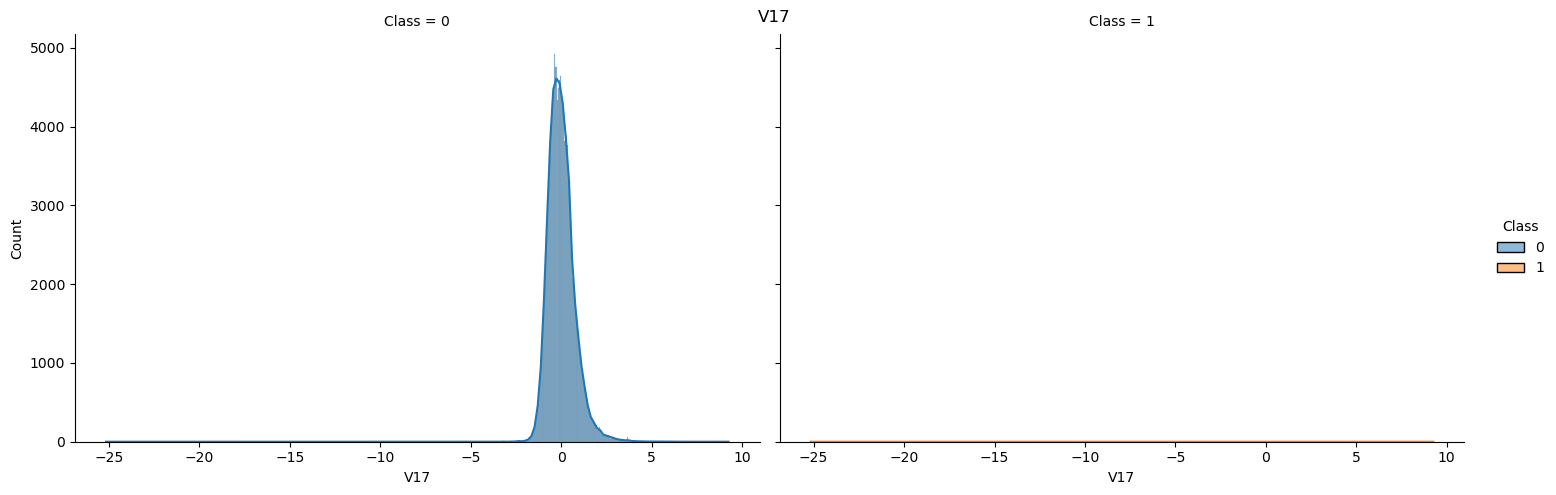

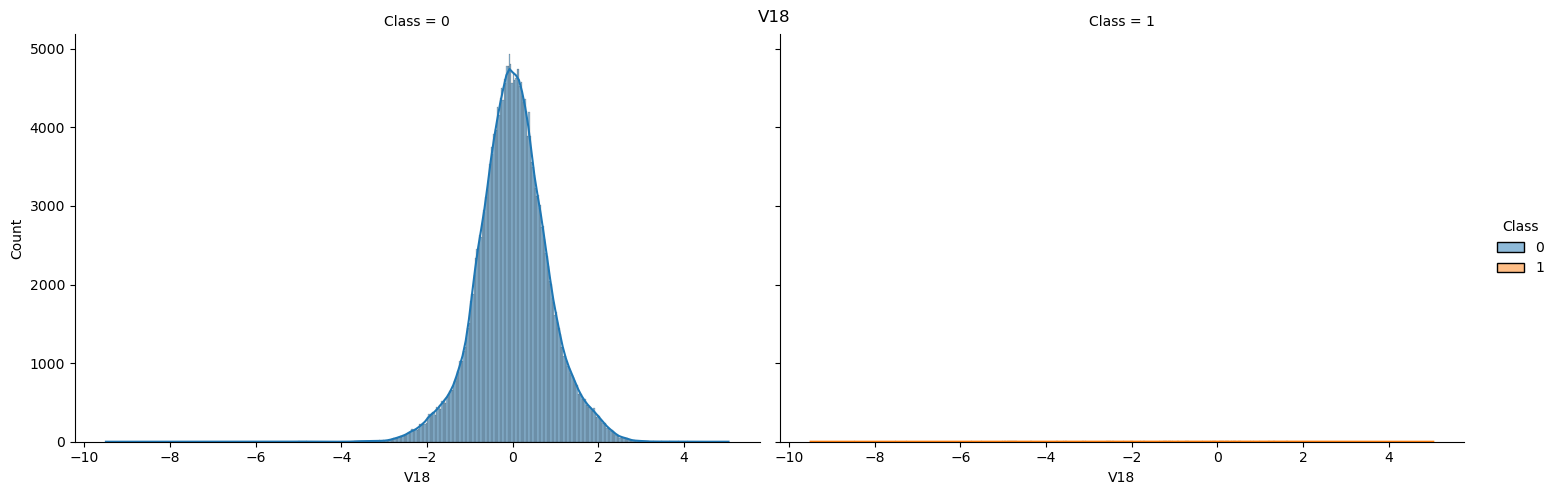

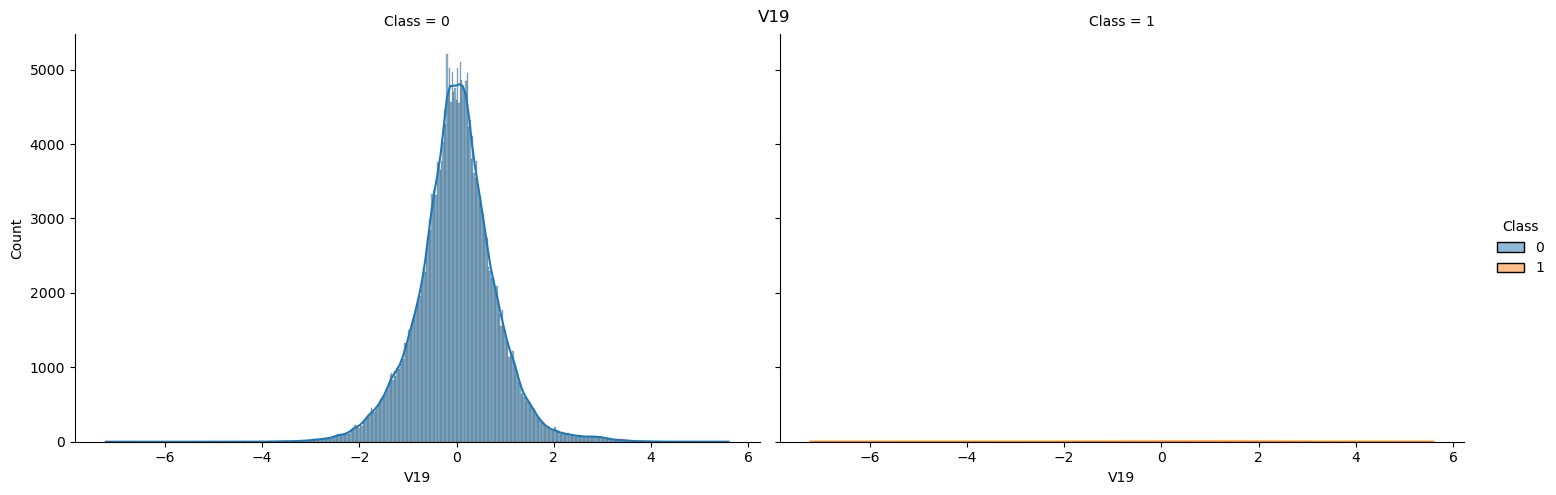

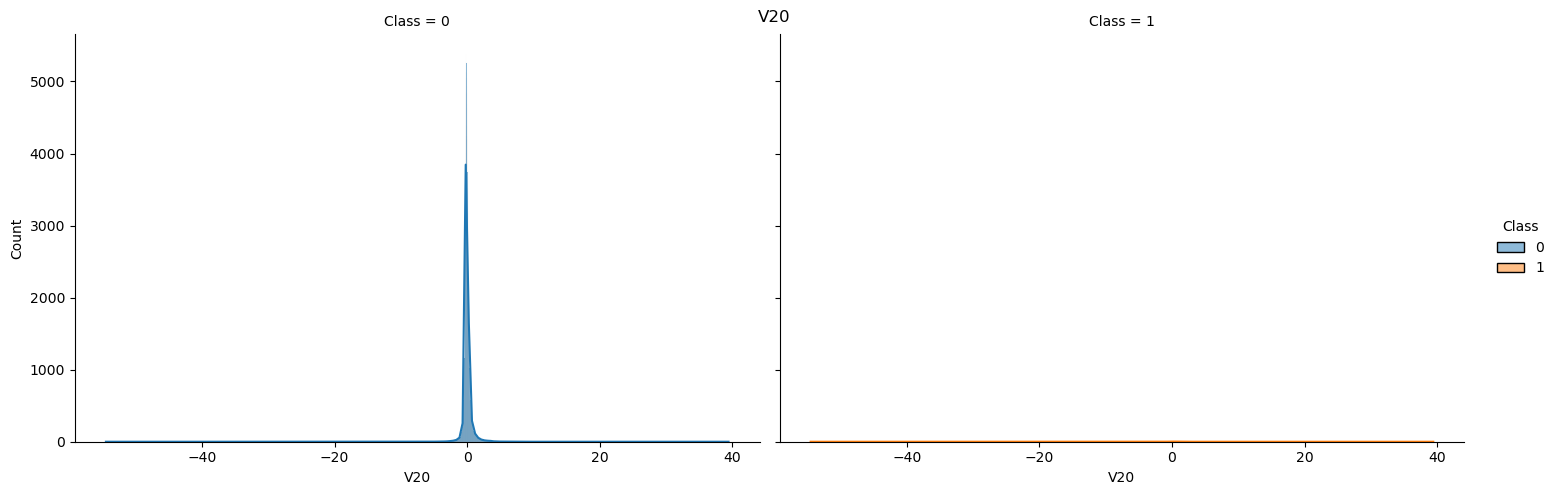

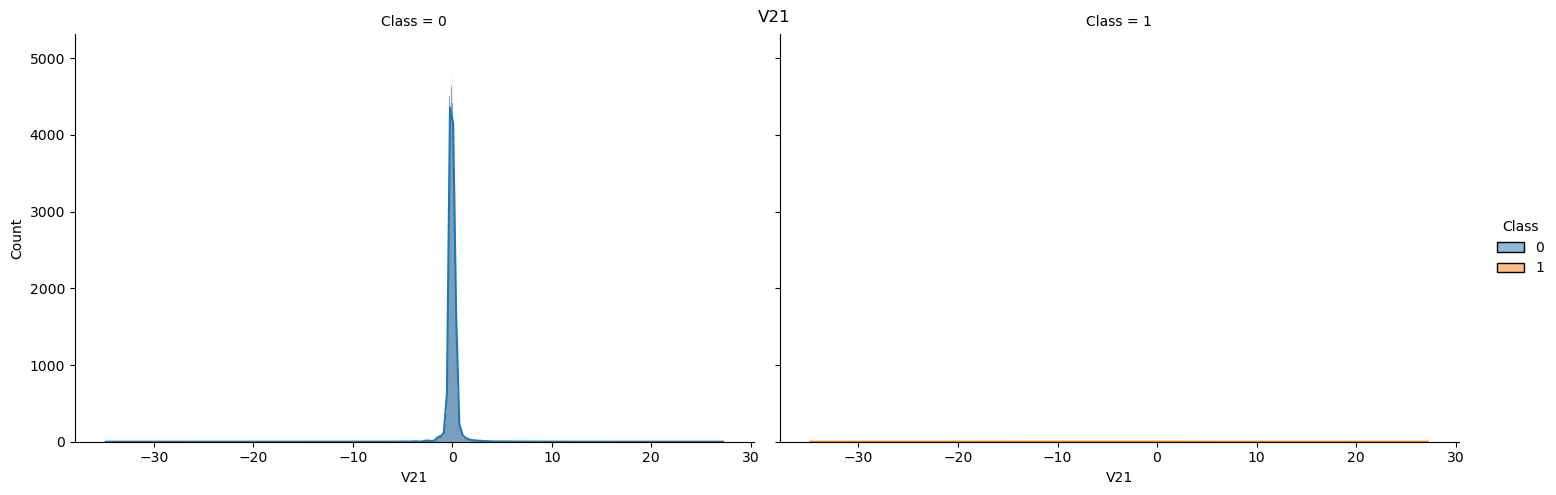

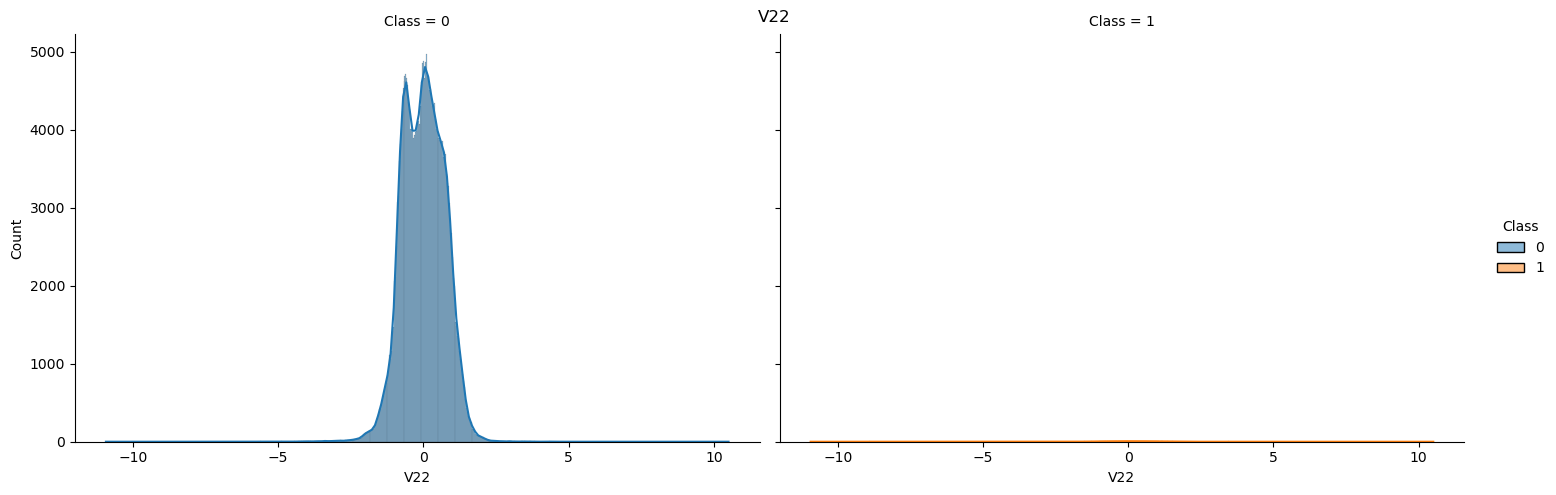

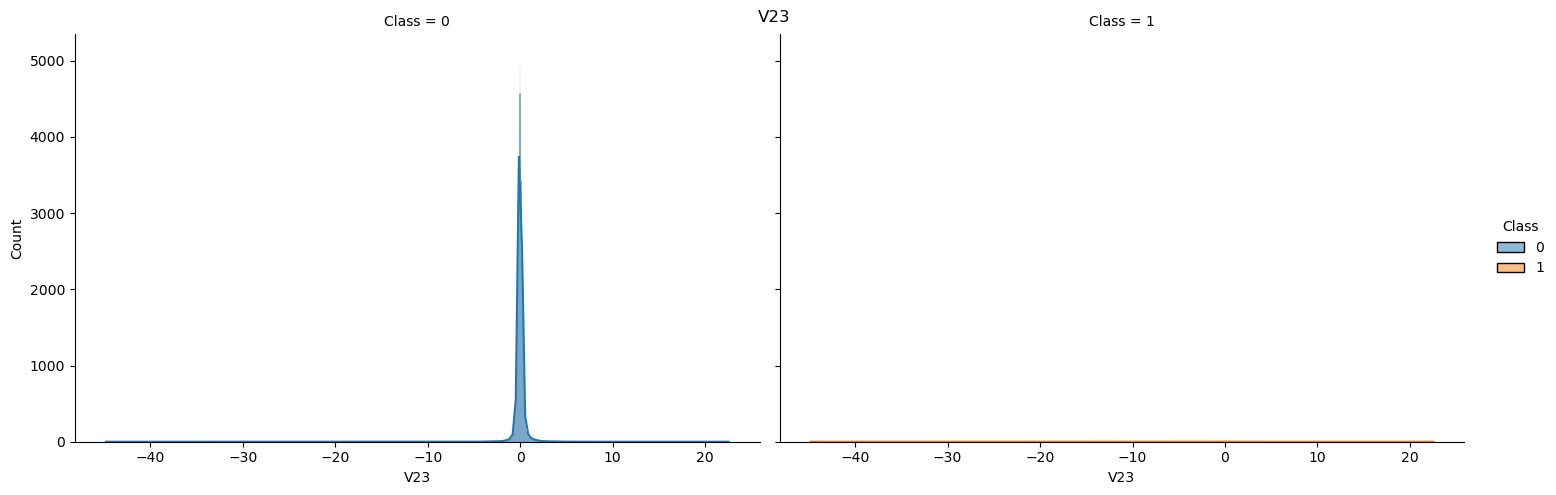

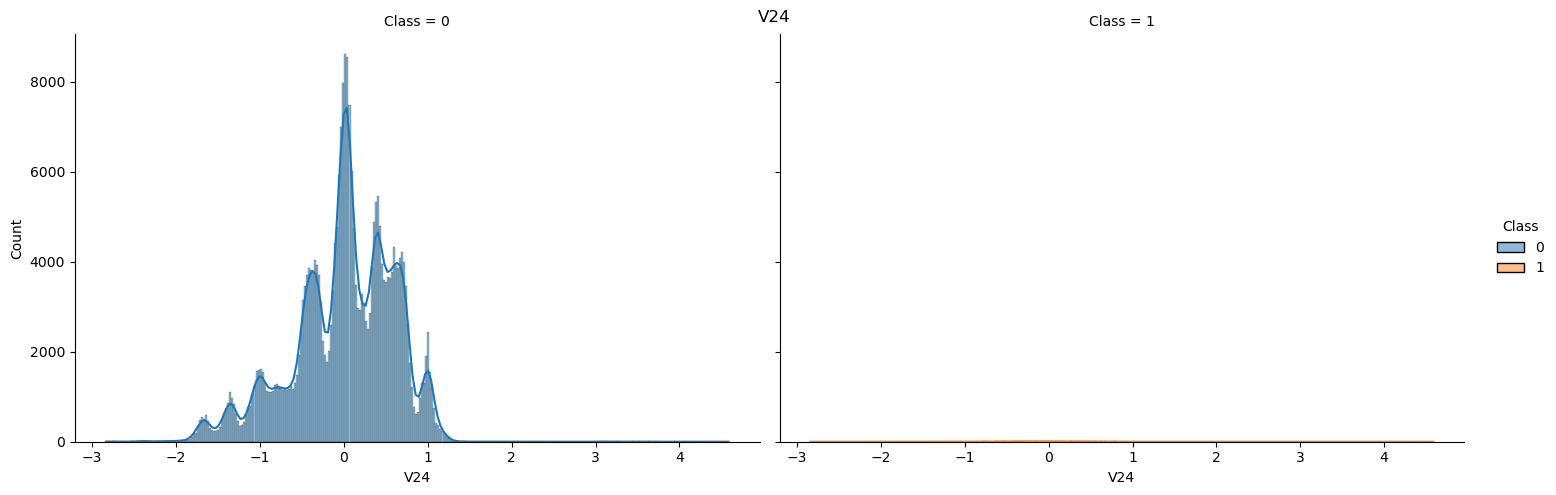

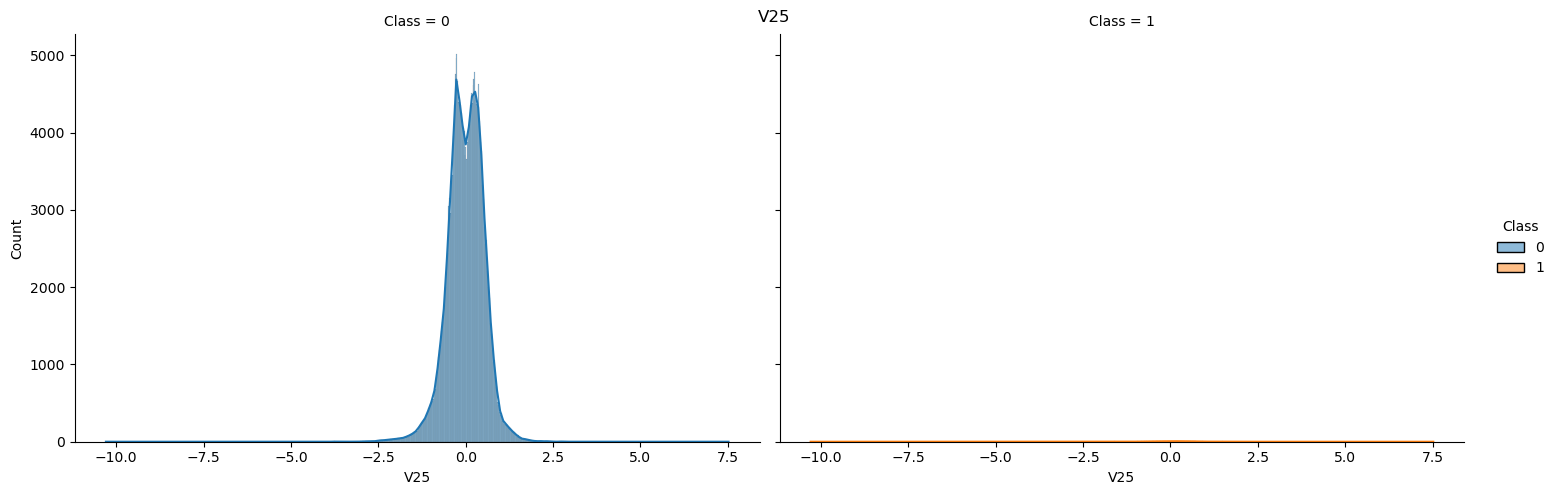

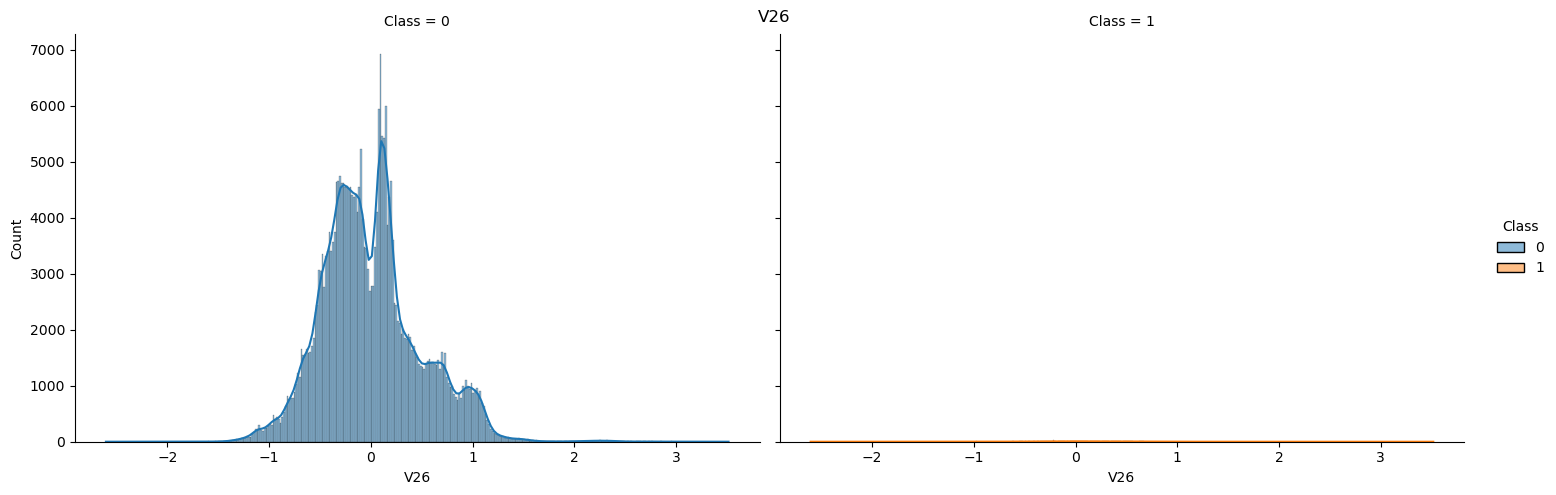

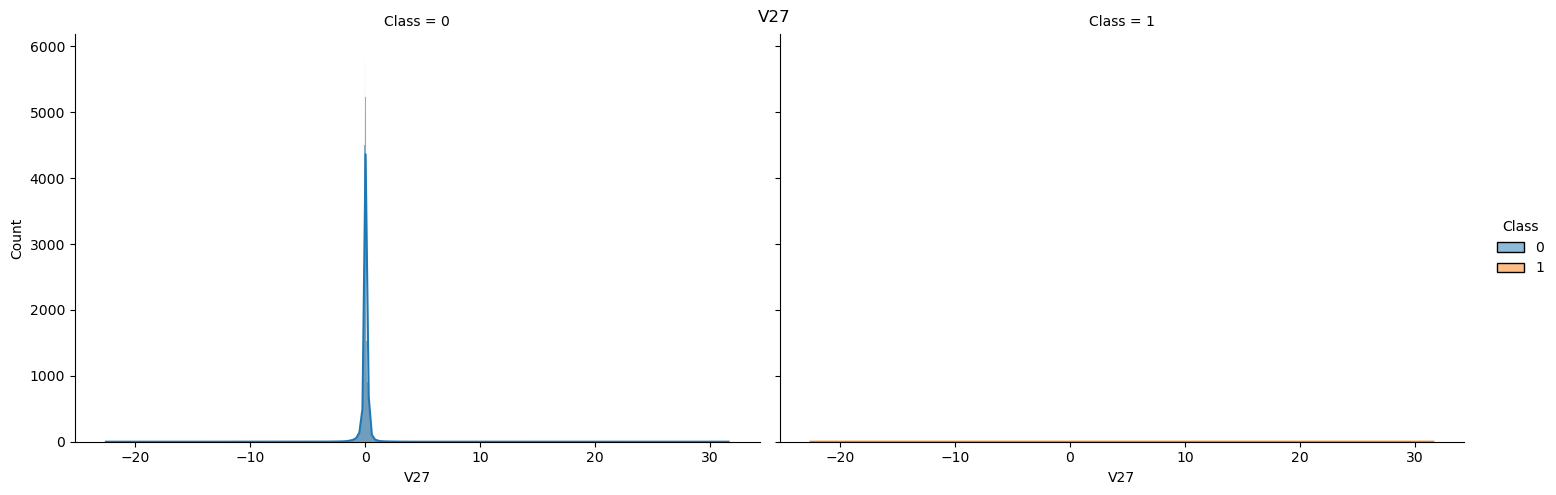

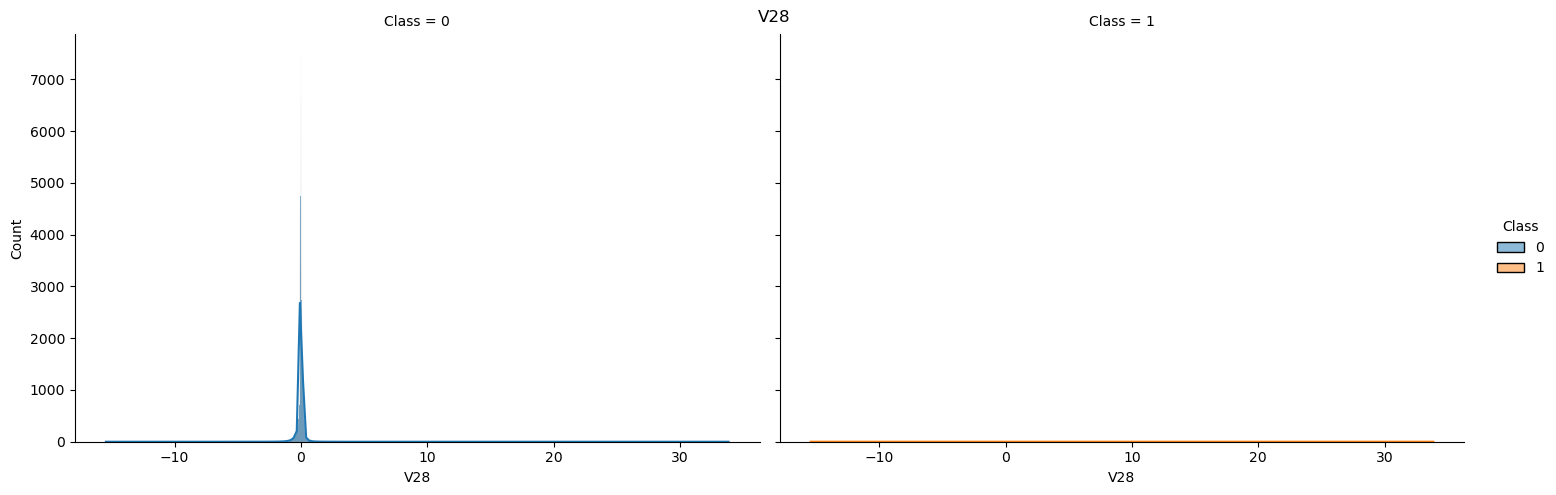

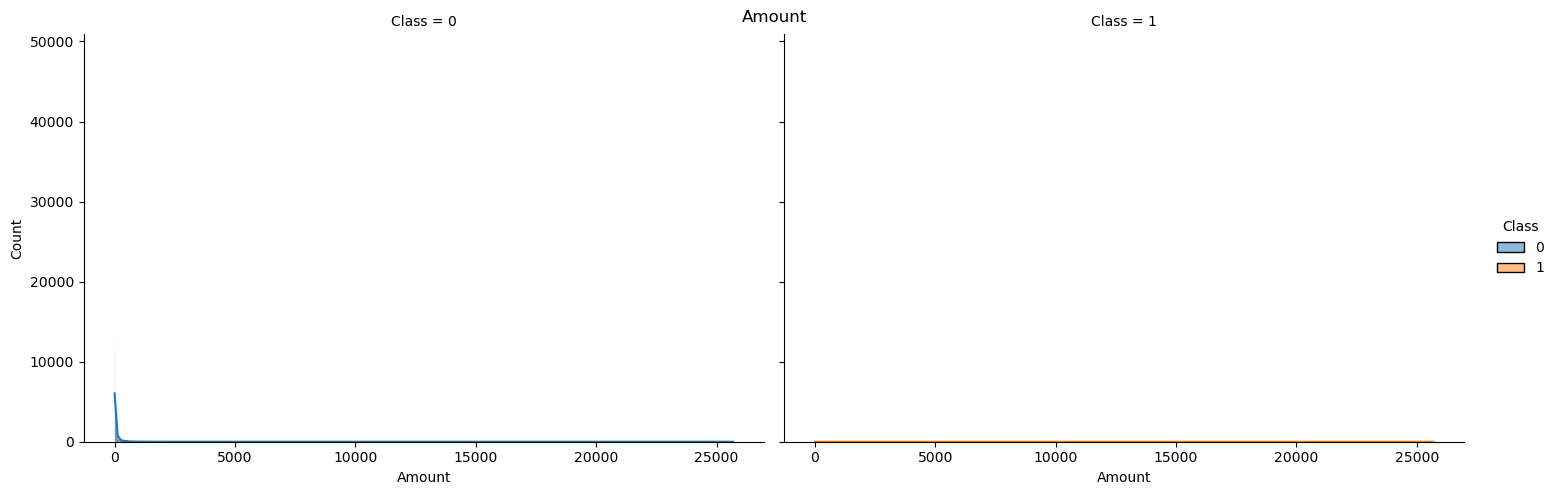

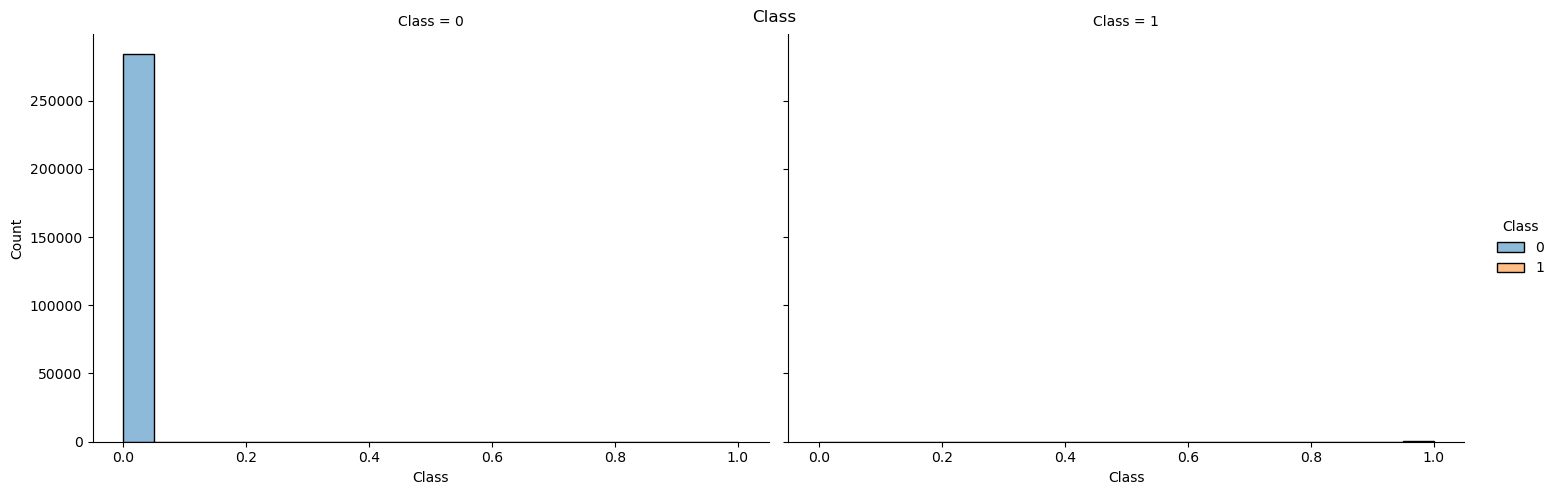

In [7]:
for feat in df.columns:
  sns.displot(data=df, x=feat, kde=True, hue='Class', col='Class', aspect=1.5)
  plt.suptitle(feat)
  plt.show()

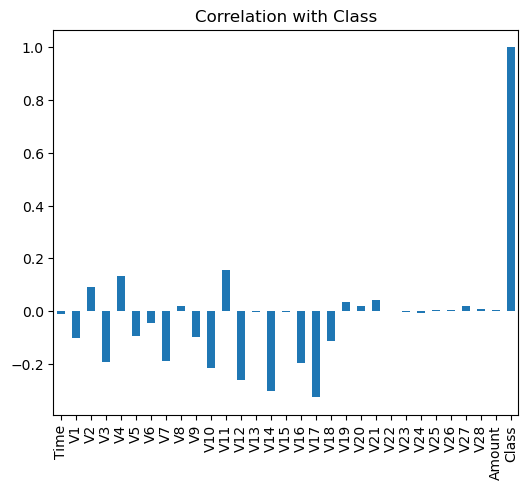

In [8]:
df.corrwith(df['Class']).plot(kind='bar', figsize=(6, 5))
plt.title('Correlation with Class')
plt.show()

In [9]:
df.info(
    verbose=True,
    show_counts=True
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

No Null Values

# Preprocessing

In [6]:
df['upper time'] = np.where(df['Time'] > 100000, 1, 0)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,upper time
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,1


<Axes: xlabel='Time', ylabel='Count'>

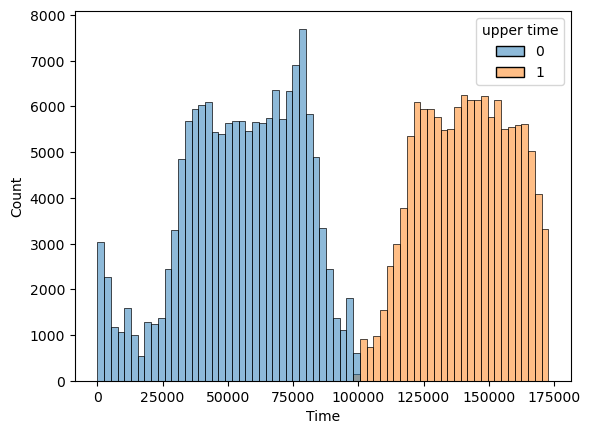

In [7]:
sns.histplot(data=df, x='Time', hue='upper time')

In [8]:
df.groupby('upper time')['Class'].mean()

upper time
0    0.002146
1    0.001236
Name: Class, dtype: float64

# Modeling

## Train Test Split

In [9]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'upper time'],
      dtype='object')

In [7]:
features = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26','V27','V28','Amount','upper time']

target = 'Class'

In [8]:
X = df[features]
y = df[target]

In [9]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=42)

## Smote

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_tr, y_tr = smote.fit_resample(X_tr, y_tr)

## Standardization

In [14]:
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_ts = scaler.transform(X_ts)

## Random Forest

In [19]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_tr, y_tr)

acc_tr_rf = accuracy_score(y_tr, rf.predict(X_tr))
acc_ts_rf = accuracy_score(y_ts, rf.predict(X_ts))

prec_tr_rf = precision_score(y_tr, rf.predict(X_tr))
prec_ts_rf = precision_score(y_ts, rf.predict(X_ts))

rec_tr_rf = recall_score(y_tr, rf.predict(X_tr))
rec_ts_rf = recall_score(y_ts, rf.predict(X_ts))

print(f'Train Accuracy: {acc_tr_rf}')
print(f'Test Accuracy: {acc_ts_rf}')
print(f'Train Precision: {prec_tr_rf}')
print(f'Test Precision: {prec_ts_rf}')
print(f'Train Recall: {rec_tr_rf}')
print(f'Test Recall: {rec_ts_rf}')

Train Accuracy: 1.0
Test Accuracy: 0.9995435553526912
Train Precision: 1.0
Test Precision: 0.8829787234042553
Train Recall: 1.0
Test Recall: 0.8469387755102041


<Axes: >

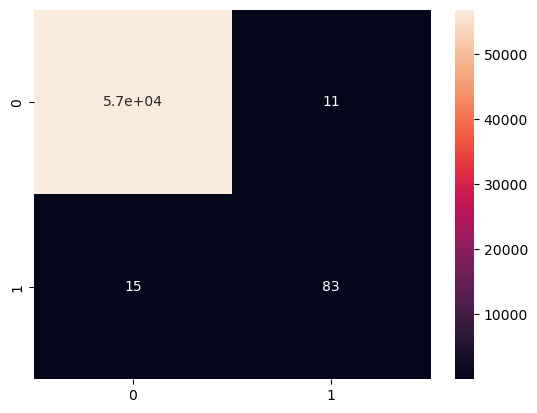

In [20]:
cm = confusion_matrix(y_ts, rf.predict(X_ts))
sns.heatmap(cm, annot=True)

## Gradient Boosting

In [21]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_tr, y_tr)

acc_tr_gb = accuracy_score(y_tr, gb.predict(X_tr))
acc_ts_gb = accuracy_score(y_ts, gb.predict(X_ts))

prec_tr_gb = precision_score(y_tr, gb.predict(X_tr))
prec_ts_gb = precision_score(y_ts, gb.predict(X_ts))

rec_tr_gb = recall_score(y_tr, gb.predict(X_tr))
rec_ts_gb = recall_score(y_ts, gb.predict(X_ts))

print(f'Train Accuracy: {acc_tr_gb}')
print(f'Test Accuracy: {acc_ts_gb}')
print(f'Train Precision: {prec_tr_gb}')
print(f'Test Precision: {prec_ts_gb}')
print(f'Train Recall: {rec_tr_gb}')
print(f'Test Recall: {rec_ts_gb}')

Train Accuracy: 0.9887690095888785
Test Accuracy: 0.9941188862750606
Train Precision: 0.9943438008591019
Test Precision: 0.21307506053268765
Train Recall: 0.9831304324887559
Test Recall: 0.8979591836734694


<Axes: >

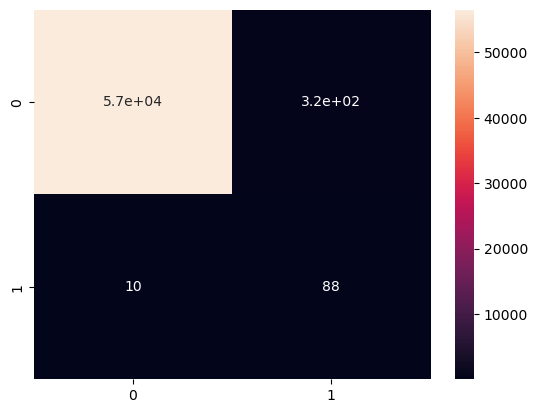

In [22]:
cm = confusion_matrix(y_ts, gb.predict(X_ts))
sns.heatmap(cm, annot=True)

## Logistic / Bagging

In [15]:
log = BaggingClassifier(estimator=LogisticRegression(), random_state=42)
log.fit(X_tr, y_tr)

acc_tr_log = accuracy_score(y_tr, log.predict(X_tr))
acc_ts_log = accuracy_score(y_ts, log.predict(X_ts))

prec_tr_log = precision_score(y_tr, log.predict(X_tr))
prec_ts_log = precision_score(y_ts, log.predict(X_ts))

rec_tr_log = recall_score(y_tr, log.predict(X_tr))
rec_ts_log = recall_score(y_ts, log.predict(X_ts))

print(f'Train Accuracy: {acc_tr_log}')
print(f'Test Accuracy: {acc_ts_log}')
print(f'Train Precision: {prec_tr_log}')
print(f'Test Precision: {prec_ts_log}')
print(f'Train Recall: {rec_tr_log}')
print(f'Test Recall: {rec_ts_log}')

Train Accuracy: 0.9790965966296037
Test Accuracy: 0.9913451072644921
Train Precision: 0.9914669456897252
Test Precision: 0.15532286212914484
Train Recall: 0.9665114684041838
Test Recall: 0.9081632653061225


<Axes: >

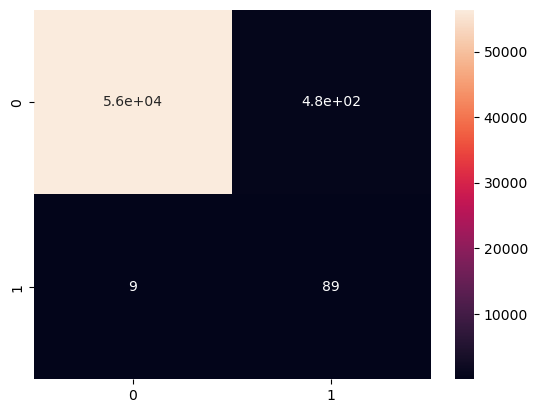

In [16]:
cm = confusion_matrix(y_ts, log.predict(X_ts))
sns.heatmap(cm, annot=True)

# Summary

In [ ]:
train_acc_scores = [acc_tr_rf, acc_tr_gb, acc_tr_log]
test_acc_scores = [acc_ts_rf, acc_ts_gb, acc_ts_log]

train_precision_scores = [prec_tr_rf, prec_tr_gb, prec_tr_log]
test_precision_scores = [prec_ts_gb, prec_ts_gb, prec_ts_log ]

train_recall_scores = [rec_tr_rf, rec_tr_gb, rec_tr_log]
test_recall_scores = [rec_ts_rf, rec_ts_gb, rec_ts_log]

dict_scores = {
    'Train Recall': train_recall_scores,
    'Test Recall': test_recall_scores,
    'Train Accuracy': train_acc_scores,
    'Test Accuracy': test_acc_scores,
    'Train Precision': train_precision_scores,
    'Test Precision': test_precision_scores}

pd.DataFrame(dict_scores, index=['Random Forest', 'Gradient Boosting', 'Logistic Regression'])

In [19]:
# --- Cell to Compare, Save, and Upload ---
import joblib
import os

# 1. Compare the Models (Assuming you have these variables from your previous cells)
# You should have 'recall' and 'f1' scores for both models.
# If you don't have them variables yet, just look at your print outputs.

# Let's assume Logistic Regression (lr_model) was the winner for high Recall
# (Replace 'model' with 'gb_model' if Gradient Boost was better)
best_model = log 
best_model_name = "Logistic Regression" 
sagemaker_session = sagemaker.Session()
print(f"Selected Best Model: {best_model_name}")

# 2. Save the Model Locally
# This saves the model from memory to the hard drive of your JupyterLab instance
model_file_name = 'model.joblib'
joblib.dump(best_model, model_file_name)
print(f"Model saved locally as: {model_file_name}")
model_prefix = "fraud-project/models/v1"

# 3. Upload the Model to S3
# This sends the file from your hard drive to the S3 bucket
# This is crucial! Steps 3 (API) and 4 (Pipeline) cannot see your notebook's hard drive.
# They can ONLY see S3.
model_s3_path = f"s3://{bucket}/{model_prefix}/{model_file_name}"
sagemaker_session.upload_data(path=model_file_name, bucket=bucket, key_prefix=model_prefix)

print(f"Model successfully uploaded to: {model_s3_path}")
print("You are now ready to create inference.py!")

Selected Best Model: Logistic Regression
Model saved locally as: model.joblib
Model successfully uploaded to: s3://iu-fraud-project-s3/fraud-project/models/v1/model.joblib
You are now ready to create inference.py!


#

In [9]:
%%writefile preprocess.py
import argparse
import os
import pandas as pd
import glob
from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    print("Starting preprocessing...")
    
    # Standard SageMaker paths
    base_dir = "/opt/ml/processing"
    input_dir = os.path.join(base_dir, "input")
    
    # --- THE FIX: Find ANY .csv file ---
    # This handles 'creditcard.csv', 'month_1.csv', 'month_2.csv', etc.
    csv_files = glob.glob(f"{input_dir}/*.csv")
    
    if not csv_files:
        raise ValueError(f"No CSV files found in {input_dir}")
        
    input_path = csv_files[0] # Just take the first file found
    print(f"Reading data from: {input_path}")
    # -----------------------------------

    df = pd.read_csv(input_path)
    
    # Feature Selection
    X = df.drop(['Time', 'Class'], axis=1)
    y = df['Class']
    
    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Recombine
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)
    
    # Save
    train_output_path = os.path.join(base_dir, "train", "train.csv")
    test_output_path = os.path.join(base_dir, "test", "test.csv")
    
    print(f"Saving train data to {train_output_path}")
    train_df.to_csv(train_output_path, index=False)
    
    print(f"Saving test data to {test_output_path}")
    test_df.to_csv(test_output_path, index=False)
    
    print("Preprocessing complete!")

Overwriting preprocess.py


In [11]:
%%writefile fraud_source_dir/train.py
import argparse
import os
import pandas as pd
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

if __name__ == "__main__":
    print("Starting training script...")

    # 1. Parse SageMaker Arguments
    parser = argparse.ArgumentParser()
    
    # Standard SageMaker args
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    
    # Pipeline args
    parser.add_argument("--max_iter", type=int, default=1000)
    
    # Safety: Use parse_known_args to ignore unknown SageMaker parameters
    args, _ = parser.parse_known_args()

    # 2. Load Training Data
    train_file = os.path.join(args.train, "train.csv")
    print(f"Reading training data from {train_file}")
    train_df = pd.read_csv(train_file)

    # Separate Features and Target
    X_train = train_df.drop("Class", axis=1)
    y_train = train_df["Class"]

    # 3. Apply SMOTE
    print("Applying SMOTE resampling...")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print(f"Original shape: {X_train.shape}, Resampled shape: {X_resampled.shape}")

    # 4. Create Pipeline
    print(f"Training Pipeline with max_iter={args.max_iter}...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', max_iter=args.max_iter))
    ])

    # 5. Train
    pipeline.fit(X_resampled, y_resampled)

    # 6. Save Model
    model_path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(pipeline, model_path)
    print(f"Model saved to {model_path}")

Writing fraud_source_dir/train.py


In [23]:
%%writefile evaluate.py
import json
import os
import tarfile
import pandas as pd
import joblib
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

if __name__ == "__main__":
    print("Starting evaluation script...")

    # 1. Define Paths (Standard SageMaker Processing Paths)
    # These are where SageMaker mounts your data and model inside the container
    model_path = "/opt/ml/processing/model/model.tar.gz"
    test_path = "/opt/ml/processing/test/test.csv"
    output_path = "/opt/ml/processing/evaluation/evaluation.json"

    # 2. Load Test Data
    print(f"Reading test data from {test_path}")
    df_test = pd.read_csv(test_path)
    
    # Separate Features and Target (Assuming 'Class' is the target column)
    y_test = df_test['Class']
    X_test = df_test.drop('Class', axis=1)

    # 3. Load Model
    # The training job outputs a 'model.tar.gz'. We need to extract it first.
    print(f"Extracting model from {model_path}")
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")
    
    print("Loading model.joblib...")
    model = joblib.load("model.joblib")

    # 4. Make Predictions
    print("Generating predictions...")
    predictions = model.predict(X_test)
    
    # 5. Calculate Metrics
    # We calculate the standard metrics for fraud detection
    print("Calculating metrics...")
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # 6. Save Evaluation Report (Critical Step)
    # This specific JSON format is required so SageMaker can parse it later
    report_dict = {
        "binary_classification_metrics": {
            "recall": {
                "value": recall,
                "standard_deviation": "NaN"
            },
            "precision": {
                "value": precision,
                "standard_deviation": "NaN"
            },
            "f1": {
                "value": f1,
                "standard_deviation": "NaN"
            },
            "accuracy": {
                "value": accuracy,
                "standard_deviation": "NaN"
            },
            "auc": {
                "value": auc,
                "standard_deviation": "NaN"
            }
        }
    }

    print(f"Saving evaluation report to {output_path}")
    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    with open(output_path, "w") as f:
        f.write(json.dumps(report_dict))
    
    print("Evaluation complete.")

Writing evaluate.py


In [10]:
import sagemaker
from sagemaker.workflow.parameters import ParameterInteger, ParameterString, ParameterFloat
from sagemaker.workflow.steps import ProcessingStep, TrainingStep, CacheConfig
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.conditions import ConditionGreaterThan
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.functions import JsonGet

# 1. Setup Environment
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
pipeline_name = "Fraud-Detection-Pipeline-V1"

# 2. Define Parameters (Variables you can change when running the pipeline)
processing_instance_type = ParameterString(name="ProcessingInstanceType", default_value="ml.m5.large")
training_instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.large")
input_data = ParameterString(
    name="InputData",
    # Point this to where your RAW data lives (the "Inbox")
    default_value=f"s3://iu-fraud-project-s3/creditcard.csv" 
)
model_approval_status = ParameterString(name="ModelApprovalStatus", default_value="PendingManualApproval")
# Accuracy Threshold: If the new model's F1 score is lower than this, we reject it.
f1_threshold = ParameterFloat(name="F1Threshold", default_value=0.60)

# 3. Define the Processor (The computer that runs preprocess.py & evaluate.py)
sklearn_processor = SKLearnProcessor(
    framework_version="1.0-1",
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="fraud-process",
    role=role,
    sagemaker_session=sagemaker_session
)

# --- STEP 1: PREPROCESSING ---
step_process = ProcessingStep(
    name="FraudProcessData",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input")
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test")
    ],
    code="preprocess.py"
)

# --- STEP 2: TRAINING ---
# Define the Estimator (The computer that runs train.py)
# Update the Estimator to use source_dir
sklearn_estimator = SKLearn(
    entry_point="train.py",          # The script name
    source_dir="fraud_source_dir",   
    framework_version="1.0-1",
    instance_type=training_instance_type,
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={"max_iter": 3000}
)

step_train = TrainingStep(
    name="FraudTrainModel",
    estimator=sklearn_estimator,
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv"
        )
    }
)

# --- STEP 3: EVALUATION ---
# We use the same processor as step 1, but run evaluate.py
evaluation_report = PropertyFile(
    name="EvaluationReport",
    output_name="evaluation",
    path="evaluation.json"
)

step_evaluate = ProcessingStep(
    name="FraudEvaluateModel",
    processor=sklearn_processor,
    inputs=[
        # Load the model artifact created in Step 2
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model"
        ),
        # Load the test data created in Step 1
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test"
        )
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation")
    ],
    code="evaluate.py",
    property_files=[evaluation_report]
)

# --- STEP 4: CONDITION & REGISTER ---
# Only register the model if F1-Score > Threshold
# Define the Model Registration Step
step_register = RegisterModel(
    name="FraudRegisterModel",
    estimator=sklearn_estimator,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["application/json"],
    inference_instances=["ml.m5.large"],
    transform_instances=["ml.m5.large"],
    model_package_group_name="FraudModelGroup",
    approval_status=model_approval_status
)

# --- THE FIX IS HERE ---
# Instead of step_evaluate.properties.EvaluationReport..., we use JsonGet
cond_gte = ConditionGreaterThan(
    left=JsonGet(
        step_name=step_evaluate.name,
        property_file=evaluation_report,
        json_path="binary_classification_metrics.f1.value"
    ),
    right=f1_threshold
)

step_cond = ConditionStep(
    name="FraudAccuracyCheck",
    conditions=[cond_gte],
    if_steps=[step_register],
    else_steps=[] 
)

# 5. Construct the Pipeline
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        training_instance_type,
        input_data,
        model_approval_status,
        f1_threshold
    ],
    steps=[step_process, step_train, step_evaluate, step_cond]
)

# 6. Send Pipeline Definition to SageMaker (Create/Update)
pipeline.upsert(role_arn=role)
print(f"Pipeline '{pipeline_name}' created successfully!")

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


Pipeline 'Fraud-Detection-Pipeline-V1' created successfully!


## Pipeline

In [13]:
safe_input_path = "s3://sagemaker-us-east-2-307946652610/creditcard.csv"

print(f"Starting pipeline with input: {safe_input_path}")

# 2. Start the Pipeline with this specific input
execution = pipeline.start(
    parameters={
        "InputData": safe_input_path
    }
)

print(f"Pipeline execution started: {execution.arn}")
execution.wait()

Starting pipeline with input: s3://sagemaker-us-east-2-307946652610/creditcard.csv
Pipeline execution started: arn:aws:sagemaker:us-east-2:307946652610:pipeline/Fraud-Detection-Pipeline-V1/execution/ulxewlugmksx


In [19]:
# List the steps and find the failure
steps = execution.list_steps()

print(f"Execution Status: {execution.describe()['PipelineExecutionStatus']}")

for step in steps['PipelineExecutionSteps']:
    print(f"\nStep: {step['StepName']}")
    print(f"Status: {step['StepStatus']}")
    
    # If this step failed, print the reason why
    if step['StepStatus'] == 'Failed':
        print(f"❌ FAILURE REASON: {step['FailureReason']}")

Execution Status: Succeeded


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│    3                                                                                             │
│    4 print(f"Execution Status: {execution.describe()['PipelineExecutionStatus']}")               │
│    5                                                                                             │
│ ❱  6 for step in steps['PipelineExecutionSteps'].keys:                                           │
│    7 │   print(f"\nStep: {step['StepName']}")                                                    │
│    8 │   print(f"Status: {step['StepStatus']}")                                                  │
│    9                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: list indices must be integers or slices, not str

In [15]:
steps

[{'StepName': 'FraudAccuracyCheck',
  'StartTime': datetime.datetime(2025, 11, 28, 21, 13, 6, 690000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 11, 28, 21, 13, 6, 853000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'Condition': {'Outcome': 'False'}},
  'AttemptCount': 1},
 {'StepName': 'FraudEvaluateModel',
  'StartTime': datetime.datetime(2025, 11, 28, 21, 10, 33, 898000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 11, 28, 21, 13, 6, 118000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-2:307946652610:processing-job/pipelines-ulxewlugmksx-FraudEvaluateModel-sIfw4v1Giv'}},
  'AttemptCount': 1},
 {'StepName': 'FraudTrainModel',
  'StartTime': datetime.datetime(2025, 11, 28, 21, 7, 52, 65000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 11, 28, 21, 10, 33, 389000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemak

In [10]:
import os

# 1. Create the directory
source_dir = "fraud_source_dir"
os.makedirs(source_dir, exist_ok=True)

# 2. Create requirements.txt inside that directory
# This tells SageMaker to auto-install these before running your script
requirements_path = os.path.join(source_dir, "requirements.txt")
with open(requirements_path, "w") as f:
    f.write("imbalanced-learn\n")
    f.write("pandas\n")
    f.write("scikit-learn\n")

print(f"Created {source_dir} with requirements.txt")

Created fraud_source_dir with requirements.txt


In [16]:
!aws sagemaker list-pipelines

{
    "PipelineSummaries": [
        {
            "PipelineArn": "arn:aws:sagemaker:us-east-2:307946652610:pipeline/Fraud-Detection-Pipeline-V1",
            "PipelineName": "Fraud-Detection-Pipeline-V1",
            "PipelineDisplayName": "Fraud-Detection-Pipeline-V1",
            "RoleArn": "arn:aws:iam::307946652610:role/service-role/AmazonSageMaker-ExecutionRole-20251119T153452",
            "CreationTime": "2025-11-27T19:58:57.793000+00:00",
            "LastModifiedTime": "2025-11-28T21:13:07.031000+00:00",
            "LastExecutionTime": "2025-11-28T21:02:47.084000+00:00"
        }
    ]
}


## Final Simulation of 12 months

Starting 12-Month Simulation on: Fraud-Detection-Pipeline-V1

=== SIMULATING MONTH 1 ===
   -> Generated month_1.csv (284807 rows)
   -> Uploading to: s3://sagemaker-us-east-2-307946652610/data/raw/month_1.csv
   -> Triggering Pipeline...
   -> Running: nl7trpzse72k
............. Succeeded
   -> SCORES: F1=0.1460, Recall=0.8581

=== SIMULATING MONTH 2 ===
   -> Generated month_2.csv (284807 rows)
   -> Uploading to: s3://sagemaker-us-east-2-307946652610/data/raw/month_2.csv
   -> Triggering Pipeline...
   -> Running: e49fyim53ymw
........... Succeeded
   -> SCORES: F1=0.1460, Recall=0.8581

=== SIMULATING MONTH 3 ===
   -> Generated month_3.csv (284807 rows)
   -> Uploading to: s3://sagemaker-us-east-2-307946652610/data/raw/month_3.csv
   -> Triggering Pipeline...
   -> Running: j5wgd2k8sbhm
........... Succeeded
   -> SCORES: F1=0.1460, Recall=0.8581

=== SIMULATING MONTH 4 ===
   -> Generated month_4.csv (284807 rows)
   -> Uploading to: s3://sagemaker-us-east-2-307946652610/data/raw

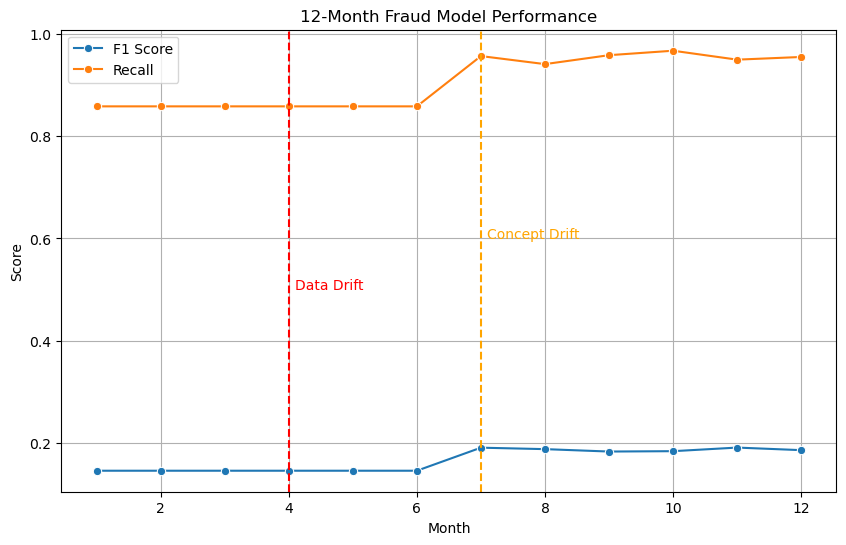

In [11]:
import pandas as pd
import boto3
import time
import json
import sagemaker
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. CONFIGURATION ---
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
pipeline_name = "Fraud-Detection-Pipeline-V1"
sm_client = boto3.client("sagemaker")
s3_client = boto3.client("s3")

# Define the EXACT path where the pipeline looks for input
# Based on your error, it wants: s3://{bucket}/data/raw/{filename}
inbox_prefix = "data/raw"

# Load the original dataset to start with
# Make sure 'creditcard.csv' is in your notebook folder!
if not os.path.exists("creditcard.csv"):
    # If not local, try to download it from S3 first
    print("Downloading base data from S3...")
    sagemaker_session.download_data(path=".", bucket=default_bucket, key_prefix="creditcard.csv")

df_base = pd.read_csv("creditcard.csv")

# --- 2. DRIFT LOGIC (The Generator) ---
def apply_drift(df, month):
    df_drift = df.copy()
    # Month 1-3: No Drift
    if month <= 3:
        return df_drift
    # Month 4-6: Data Drift (Shift V1)
    elif 4 <= month <= 6:
        drift_factor = (month - 3) * 0.1
        df_drift['V1'] = df_drift['V1'] + drift_factor
    # Month 7-12: Concept Drift (High Value = Fraud)
    elif month >= 7:
        high_value = df_drift['Amount'].quantile(0.95)
        condition = (df_drift['Amount'] > high_value) & (df_drift['Class'] == 0)
        flip_indices = df_drift[condition].sample(frac=0.1, random_state=month).index
        df_drift.loc[flip_indices, 'Class'] = 1
    return df_drift

# --- 3. THE SIMULATION LOOP ---
simulation_results = []
print(f"Starting 12-Month Simulation on: {pipeline_name}")

# Loop through months (Change range(1, 13) to range(1, 3) for a quick test)
for month in range(1, 13):
    print(f"\n=== SIMULATING MONTH {month} ===")
    
    # A. Generate Data
    filename = f"month_{month}.csv"
    df_month = apply_drift(df_base, month)
    df_month.to_csv(filename, index=False)
    print(f"   -> Generated {filename} ({len(df_month)} rows)")
    
    # B. Upload DIRECTLY to the Pipeline Inbox (Fixes the 404 Error)
    input_s3_uri = f"s3://{default_bucket}/{inbox_prefix}/{filename}"
    print(f"   -> Uploading to: {input_s3_uri}")
    
    sagemaker_session.upload_data(
        path=filename, 
        bucket=default_bucket, 
        key_prefix=inbox_prefix # This puts it exactly where the pipeline expects it
    )
    
    # C. Trigger Pipeline
    print(f"   -> Triggering Pipeline...")
    response = sm_client.start_pipeline_execution(
        PipelineName=pipeline_name,
        PipelineExecutionDisplayName=f"Month-{month}-Simulation",
        PipelineParameters=[{'Name': 'InputData', 'Value': input_s3_uri}]
    )
    execution_arn = response['PipelineExecutionArn']
    
    # D. Wait for Completion
    print(f"   -> Running: {execution_arn.split('/')[-1]}")
    while True:
        status = sm_client.describe_pipeline_execution(PipelineExecutionArn=execution_arn)['PipelineExecutionStatus']
        if status in ['Succeeded', 'Failed', 'Stopped']:
            break
        time.sleep(60)
        print(".", end="")
    print(f" {status}")
    
    # E. Capture Metrics
    if status == 'Succeeded':
        try:
            # Find Evaluation Step
            steps = sm_client.list_pipeline_execution_steps(PipelineExecutionArn=execution_arn)
            # We look for the output file 'evaluation.json'
            execution_id = execution_arn.split("/")[-1]
            eval_s3_key = f"{pipeline_name}/{execution_id}/FraudEvaluateModel/output/evaluation/evaluation.json"
            
            obj = s3_client.get_object(Bucket=default_bucket, Key=eval_s3_key)
            metrics = json.loads(obj['Body'].read())
            
            f1 = metrics['binary_classification_metrics']['f1']['value']
            recall = metrics['binary_classification_metrics']['recall']['value']
            
            print(f"   -> SCORES: F1={f1:.4f}, Recall={recall:.4f}")
            simulation_results.append({'Month': month, 'F1': f1, 'Recall': recall})
        except Exception as e:
            print(f"   -> Error fetching metrics: {e}")
            
# --- 4. FINAL PLOT ---
if simulation_results:
    res_df = pd.DataFrame(simulation_results)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=res_df, x='Month', y='F1', marker='o', label='F1 Score')
    sns.lineplot(data=res_df, x='Month', y='Recall', marker='o', label='Recall')
    plt.axvline(x=4, color='red', linestyle='--'); plt.text(4.1, 0.5, 'Data Drift', color='red')
    plt.axvline(x=7, color='orange', linestyle='--'); plt.text(7.1, 0.6, 'Concept Drift', color='orange')
    plt.title('12-Month Fraud Model Performance'); plt.ylabel('Score'); plt.xlabel('Month'); plt.grid(True); plt.show()

In [8]:
# Get the last failed execution
executions = sm_client.list_pipeline_executions(PipelineName=pipeline_name)['PipelineExecutionSummaries']
last_arn = executions[0]['PipelineExecutionArn']

print(f"Checking failure for: {last_arn}")
steps = sm_client.list_pipeline_execution_steps(PipelineExecutionArn=last_arn)['PipelineExecutionSteps']

for step in steps:
    if step['StepStatus'] == 'Failed':
        print(f"\n❌ FAILED STEP: {step['StepName']}")
        print(f"REASON: {step['FailureReason']}")

Checking failure for: arn:aws:sagemaker:us-east-2:307946652610:pipeline/Fraud-Detection-Pipeline-V1/execution/xlad1l5rdwqe
